#### Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from textwrap import wrap
import datetime as dt
import seaborn as sns; sns.set()
import geopandas

#plt.style.use("whitepaper")


Bad key "text.kerning_factor" on line 4 in
C:\Users\Samuel\miniconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


# Introduction

This notebook will describe the analytic steps and idea that lead to the figures and analysis in this blog:
***INSERT LINK HERE***

The intial section will detail the steps taken to load and manipulate initial the data sources, then the statistical methods that were used to determine the outlying Local Authorites (LA) in a range of industries and age brackets.

All the data used here can be found in the SQL database and downloaded or called via API, you can find a description of each table here: ***INSERT LINK HERE***

Some things you could try to adapt this notebook for:
* Include other industries in your analysis
* Not only use the latest furlough data but older datapoints too
* Replace age breakdown with ethnicity or private/public sector breakdown, these data are in the same format and can be found in the ***INSERT PLACE WHERE THE LINKS ARE FOUND***
* Link Coronavirus cases data
* Flip the analysis and investigate the occupation types instead of industry
* Something else!

## Geojson

In [3]:
## geojson we have edited to include all relevant LAs
#### This geojson should be downloaded from the blob store
geoData = geopandas.read_file("HeathersFinal.geojson")
## Rename column for ease of merging later
geoData["AREA_CODE"] = geoData["lad17cd"] 

## Furlough rates data

In [4]:
## furlough rates data by industry compiled from government reports
## https://www.gov.uk/government/statistics/coronavirus-job-retention-scheme-statistics-august-2020
furloughRates = pd.read_csv("furlough_rates.csv")
furloughRates.head()

,INDUSTRY,RATES,DATE
0,Human health and social work activities,6.1,05/04/20
1,Education,10.0,05/04/20
2,Water supply and waste management,11.6,05/04/20
3,Information and communication,12.0,05/04/20
4,Professional scientific and technical activities,13.6,05/04/20


In [5]:
furloughRates.DATE = pd.to_datetime(furloughRates.DATE)
numberOfDates = furloughRates.DATE.nunique()
v = furloughRates.INDUSTRY.value_counts()
## filter such that only industries with data for all dates
furloughRates = furloughRates[furloughRates.INDUSTRY.isin(v.index[v.gt(numberOfDates-1)])]
## in later stages we will take the rates from the latest date, this is not
## the same in all industries due to changes in reporting

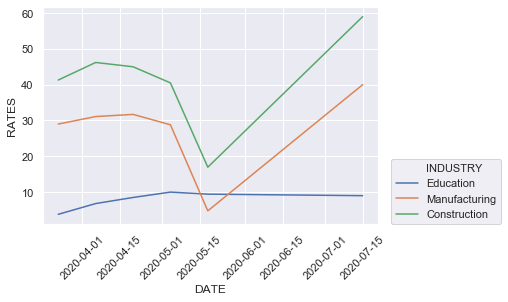

In [6]:
sns.lineplot(x="DATE", y="RATES", hue="INDUSTRY", data=furloughRates)
plt.legend(loc=(1.04,0))
plt.xticks(rotation=45);

## Total Jobs data

In [7]:
## This data relates the number of jobs in each LA by industry
totalJobs = pd.read_csv("uk-occupations2018.csv")

In [8]:
totalJobs

,local authority: district / unitary (as of April 2019),"A : Agriculture, forestry and fishing",B : Mining and quarrying,C : Manufacturing,"D : Electricity, gas, steam and air conditioning supply","E : Water supply; sewerage, waste management and remediation activities",F : Construction,G : Wholesale and retail trade; repair of motor vehicles and motorcycles,H : Transportation and storage,I : Accommodation and food service activities,...,L : Real estate activities,"M : Professional, scientific and technical activities",N : Administrative and support service activities,O : Public administration and defence; compulsory social security,P : Education,Q : Human health and social work activities,"R : Arts, entertainment and recreation",S : Other service activities,T : Activities of households as employers;undifferentiated goods-and services-producing activities of households for own use,U : Activities of extraterritorial organisations and bodies
0,Darlington,450,100,4000,0,250,1750,7000,3000,3000,...,500,3500,4000,2500,3500,8000,1000,1250,0,0
1,County Durham,4000,300,26000,450,2000,11000,25000,8000,12000,...,3000,6000,10000,14000,20000,23000,3500,4000,0,0
2,Hartlepool,175,10,3500,800,450,1750,4500,1000,2250,...,350,1000,1250,1750,3500,6000,800,600,0,0
3,Middlesbrough,50,30,3000,300,125,3000,8000,2000,3500,...,1500,2000,5000,5000,7000,15000,1250,1000,0,0
4,Northumberland,6000,300,12000,300,2000,6000,17000,4000,11000,...,2250,4500,6000,3000,9000,19000,3000,3000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367,South Lanarkshire,2500,125,11000,3000,1000,9000,20000,4500,8000,...,1750,6000,9000,8000,7000,18000,3000,2250,0,0
368,Stirling,1750,50,3000,25,300,3000,8000,1250,5000,...,900,3000,5000,2000,4500,5000,1500,900,0,0
369,West Dunbartonshire,200,20,2500,100,350,1250,4500,1000,3000,...,400,1000,1500,3500,3000,6000,1000,600,0,0
370,West Lothian,900,75,7000,45,450,5000,14000,5000,3000,...,900,4500,8000,5000,4500,9000,1750,1250,0,0


## TotalJobs percentage

In [9]:
## Calculating the percantage of jobs that each industry supplies for each LA by summing each LA and 
## converting the industry columns to be a percentage of that totaltotalJobsPerc = totalJobs

totalJobsPerc = totalJobs

In [10]:
totalJobsPerc["TOTAL"] = totalJobsPerc.sum(axis=1)
for col in totalJobsPerc.columns[1:]:
    totalJobsPerc[col] = totalJobsPerc[col] / totalJobsPerc["TOTAL"]

In [11]:
totalJobsPerc.head()


,local authority: district / unitary (as of April 2019),"A : Agriculture, forestry and fishing",B : Mining and quarrying,C : Manufacturing,"D : Electricity, gas, steam and air conditioning supply","E : Water supply; sewerage, waste management and remediation activities",F : Construction,G : Wholesale and retail trade; repair of motor vehicles and motorcycles,H : Transportation and storage,I : Accommodation and food service activities,...,"M : Professional, scientific and technical activities",N : Administrative and support service activities,O : Public administration and defence; compulsory social security,P : Education,Q : Human health and social work activities,"R : Arts, entertainment and recreation",S : Other service activities,T : Activities of households as employers;undifferentiated goods-and services-producing activities of households for own use,U : Activities of extraterritorial organisations and bodies,TOTAL
0,Darlington,0.009365,0.002081,0.083247,0.000000,0.005203,0.036420,0.145682,0.062435,0.062435,...,0.072841,0.083247,0.052029,0.072841,0.166493,0.020812,0.026015,0.0,0.0,1.0
1,County Durham,0.022727,0.001705,0.147727,0.002557,0.011364,0.062500,0.142045,0.045455,0.068182,...,0.034091,0.056818,0.079545,0.113636,0.130682,0.019886,0.022727,0.0,0.0,1.0
2,Hartlepool,0.005769,0.000330,0.115378,0.026372,0.014834,0.057689,0.148343,0.032965,0.074172,...,0.032965,0.041207,0.057689,0.115378,0.197791,0.026372,0.019779,0.0,0.0,1.0
3,Middlesbrough,0.000826,0.000496,0.049583,0.004958,0.002066,0.049583,0.132220,0.033055,0.057846,...,0.033055,0.082638,0.082638,0.115693,0.247913,0.020659,0.016528,0.0,0.0,1.0
4,Northumberland,0.054299,0.002715,0.108597,0.002715,0.018100,0.054299,0.153846,0.036199,0.099548,...,0.040724,0.054299,0.027149,0.081448,0.171946,0.027149,0.027149,0.0,0.0,1.0


## Loading occupation and industry code mapping

In [12]:
## This data is the mapping between the industries that we have loaded previously and the occupation 
## type within, we need this as the age breackdown data is provided in occupations rather than industries
industryJobs = pd.read_csv("jobtypebyindustry_v2.csv", index_col="Unnamed: 0", thousands=",", decimal=".")

In [13]:
industryJobs.head()

,"1 A Agriculture, forestry and fishing",2 B Mining and quarrying,3 C Manufacturing,"4 D Electricity, gas, air cond supply","5 E Water supply, sewerage, waste",6 F Construction,"7 G Wholesale, retail, repair of vehicles",8 H Transport and storage,9 I Accommodation and food services,10 J Information and communication,...,12 L Real estate activities,"13 M Prof, scientific, technical activ.",14 N Admin and support services,15 O Public admin and defence,16 P Education,17 Q Health and social work,"18 R Arts, entertainment and recreation",19 S Other service activities,20 T Households as employers,21 U Extraterritorial organisations
11 Corporate Managers And Directors,16054,17684,351882,17835,12930,264090,417725,111181,30632,160327,...,35004,266400,109932,160655,60767,167603,34446,46797,0,6726
12 Other Managers And Proprietors,26442,879,24426,1522,7439,44361,162168,16908,226649,25999,...,86310,58414,62484,23473,32487,85482,65749,43197,0,0
"21 Science, Engineering, Tech Professionals",4771,24928,291454,28828,15590,107400,64658,28018,3351,486682,...,7167,293915,38039,116024,99783,62848,27521,35702,0,2756
22 Health Professionals,0,0,9538,459,0,0,54060,0,0,0,...,0,30293,7418,105640,22254,1175551,2305,16843,0,0
23 Teaching And Educational Professionals,0,0,1476,0,0,2068,1698,0,1803,2422,...,0,4262,8384,17570,1470140,35427,9995,12152,0,0


# Occupation and Age bracket merging

In [14]:
## load the age data
ageData = pd.read_csv("agedata.csv", index_col="Unnamed: 0", thousands=",")

In [15]:
ageData.dtypes

 16-24     float64
 25-49     float64
 50-64     float64
 65+       float64
dtype: object

In [16]:
colList = list(ageData.columns)
for x in colList:
    ageData[x] = pd.to_numeric(ageData[x])

In [17]:
ageData.head()

,16-24,25-49,50-64,65+
11 Corporate Managers And Directors,43236.0,1458464.0,860528.0,131508.0
12 Other Managers And Proprietors,54621.0,531397.0,341723.0,81244.0
"21 Science, Engineering, Tech Professionals",113432.0,1281813.0,414805.0,32856.0
22 Health Professionals,60658.0,935034.0,404854.0,35821.0
23 Teaching And Educational Professionals,83149.0,1016639.0,417665.0,58731.0


In [18]:
ageData["Sum"] = ageData.sum(axis=1)

In [19]:
agePercentagesDict = {}
## Calculating the percentage of each age group in each occupation 'role'
for col in ageData.columns:
    values = []
    for index, row in ageData.iterrows():
        values.append(row[col]/row["Sum"])
    agePercentagesDict[col] = values
        
agePercentage = pd.DataFrame(agePercentagesDict)

In [20]:
## re-indexing with the original index
agePercentage = agePercentage.set_index(ageData.index)

In [21]:
## end product is a df with the percentages of each occupation by age group, this can be multiplied once we 
## the estimated total jobs by occupation by industry in each LA
agePercentage

,16-24,25-49,50-64,65+,Sum
11 Corporate Managers And Directors,0.017338,0.584851,0.345076,0.052735,1.0
12 Other Managers And Proprietors,0.054135,0.526665,0.338680,0.080521,1.0
"21 Science, Engineering, Tech Professionals",0.061551,0.695539,0.225082,0.017828,1.0
22 Health Professionals,0.042230,0.650972,0.281860,0.024939,1.0
23 Teaching And Educational Professionals,0.052753,0.645000,0.264985,0.037262,1.0
"24 Business, Media And Public Service Professionals",0.046468,0.637834,0.279468,0.036230,1.0
"31 Science, Engineering ,Tech Associate Prof",0.112803,0.625823,0.244436,0.016938,1.0
32 Health And Social Care Associate Professionals,0.068464,0.585148,0.313355,0.033032,1.0
33 Protective Service Occupations,0.072323,0.725738,0.195970,0.005970,1.0
"34 Culture, Media And Sports Occupations",0.139570,0.596563,0.204093,0.059774,1.0


### Selecting only columns of interest

In [22]:
## The scope of our analysis was limited to these 4 industries, you can change these values to the industries you
## are interested in and reproduce the plots with minimal code tweaking
## We are also renaming the columns here to get rid of some of the unnecessary whitespace and coding

industryJobs = industryJobs.rename(columns={ 
                           " 3 C  Manufacturing ": "Manufacturing",
                           " 6 F  Construction ": "Construction",
                              ' 18 R  Arts, entertainment and recreation ' : "Arts Entertainment And Recreation",
                            ' 13 M  Prof, scientific, technical activ. ': "Professional Scientific And Technical Activities",
                            ' 9 I  Accommodation and food services ' : "Accommodation And Food Service Activities"
})
industryJobs = industryJobs[["Manufacturing", "Construction", "Arts Entertainment And Recreation", "Professional Scientific And Technical Activities", "Accommodation And Food Service Activities"]]

In [23]:
industryJobs

,Manufacturing,Construction,Arts Entertainment And Recreation,Professional Scientific And Technical Activities,Accommodation And Food Service Activities
11 Corporate Managers And Directors,351882,264090,34446,266400,30632
12 Other Managers And Proprietors,24426,44361,65749,58414,226649
"21 Science, Engineering, Tech Professionals",291454,107400,27521,293915,3351
22 Health Professionals,9538,0,2305,30293,0
23 Teaching And Educational Professionals,1476,2068,9995,4262,1803
"24 Business, Media And Public Service Professionals",106516,136262,52357,535375,8112
"31 Science, Engineering ,Tech Associate Prof",153540,43373,7743,91144,1888
32 Health And Social Care Associate Professionals,12690,5816,4126,7272,2332
33 Protective Service Occupations,2273,1110,0,3859,0
"34 Culture, Media And Sports Occupations",34492,8651,260746,178073,6353


### Calculating numbers of industry jobs with age breakdown

In [24]:
## loop to calculate the number of jobs with age breakdown for each industry and the percantage
## which we will later use to calculate the number of jobs within each LA by age and industry breakdown

ageJobData = {}
ind = []
age = []
data = []
dataPerc = []
for x in industryJobs.columns:
    for y in agePercentage.columns[:-1]: ## not including the sum column
        values = industryJobs[x]*agePercentage[y]
        data.append(sum(values))
        dataPerc.append(sum(values) / industryJobs[x].sum())
        age.append(y)
        ind.append(x)
            
ageJobData["Industry"] = ind
ageJobData["Age"] = age
ageJobData["Number of Jobs"] = data
ageJobData["Percentage of Jobs"] = dataPerc

ageJobData = pd.DataFrame(ageJobData)

In [25]:
ageJobData

,Industry,Age,Number of Jobs,Percentage of Jobs
0,Manufacturing,16-24,3.103695e+05,0.106192
1,Manufacturing,25-49,1.691341e+06,0.578689
2,Manufacturing,50-64,8.161024e+05,0.279228
3,Manufacturing,65+,1.048980e+05,0.035891
4,Construction,16-24,2.215905e+05,0.095366
5,Construction,25-49,1.318421e+06,0.567412
6,Construction,50-64,6.874829e+05,0.295874
7,Construction,65+,9.607499e+04,0.041348
8,Arts Entertainment And Recreation,16-24,1.152721e+05,0.131953
9,Arts Entertainment And Recreation,25-49,4.877969e+05,0.558385


## Loading total Jobs and furlough rate data for desired industries

In [26]:
## reloading the industry data as we no longer need the total column
totalJobs = pd.read_csv("uk-occupations2018.csv")

In [27]:
totalJobs.head()

,local authority: district / unitary (as of April 2019),"A : Agriculture, forestry and fishing",B : Mining and quarrying,C : Manufacturing,"D : Electricity, gas, steam and air conditioning supply","E : Water supply; sewerage, waste management and remediation activities",F : Construction,G : Wholesale and retail trade; repair of motor vehicles and motorcycles,H : Transportation and storage,I : Accommodation and food service activities,...,L : Real estate activities,"M : Professional, scientific and technical activities",N : Administrative and support service activities,O : Public administration and defence; compulsory social security,P : Education,Q : Human health and social work activities,"R : Arts, entertainment and recreation",S : Other service activities,T : Activities of households as employers;undifferentiated goods-and services-producing activities of households for own use,U : Activities of extraterritorial organisations and bodies
0,Darlington,450,100,4000,0,250,1750,7000,3000,3000,...,500,3500,4000,2500,3500,8000,1000,1250,0,0
1,County Durham,4000,300,26000,450,2000,11000,25000,8000,12000,...,3000,6000,10000,14000,20000,23000,3500,4000,0,0
2,Hartlepool,175,10,3500,800,450,1750,4500,1000,2250,...,350,1000,1250,1750,3500,6000,800,600,0,0
3,Middlesbrough,50,30,3000,300,125,3000,8000,2000,3500,...,1500,2000,5000,5000,7000,15000,1250,1000,0,0
4,Northumberland,6000,300,12000,300,2000,6000,17000,4000,11000,...,2250,4500,6000,3000,9000,19000,3000,3000,0,0


In [28]:
## reload furlough to get all the industries back, we will take the latest date for each even if there are few
## dates with data for that industry
furloughRates = pd.read_csv("furlough_rates.csv")
furloughRates.DATE = pd.to_datetime(furloughRates.DATE)
numberOfDates = furloughRates.DATE.nunique()

In [29]:
allowedInd = ["Manufacturing", "Construction", "Professional Scientific And Technical Activities", "Arts Entertainment And Recreation", "Accommodation And Food Service Activities"]
furloughRates = furloughRates[furloughRates["INDUSTRY"].isin(allowedInd)]

In [30]:
## clearly there are less data points for the latter 3 industries, we will take the latest
furloughRates["INDUSTRY"].value_counts()

Manufacturing                                       6
Construction                                        6
Accommodation And Food Service Activities           3
Professional Scientific And Technical Activities    3
Arts Entertainment And Recreation                   3
Name: INDUSTRY, dtype: int64

In [31]:
## programmatically finding the latest date of furlough data for each industry (more pythonic way is definitely
## possible)
lod = []
for ind in allowedInd:
    sliceDf = furloughRates[furloughRates["INDUSTRY"]==ind]
    maxDate = sliceDf["DATE"].max()
    latestRate = sliceDf[sliceDf["DATE"] == maxDate]["RATES"].values[0]
    newRow = {"Industry" : ind, "Date": maxDate, "Rate": latestRate}
    lod.append(newRow)

latestRates = pd.DataFrame(columns=["Industry", "Date", "Rate"], data=lod)
latestRates

,Industry,Date,Rate
0,Manufacturing,2020-07-15,40.00
1,Construction,2020-07-15,59.00
2,Professional Scientific And Technical Activities,2020-05-18,2.00
3,Arts Entertainment And Recreation,2020-05-18,69.80
4,Accommodation And Food Service Activities,2020-05-18,65.28


In [32]:
## taking some time to clean up the colum names to make them easier to call during analysis stage
## and also to match up with the already renamed industry columns

rename_dict = {"local authority: district / unitary (as of April 2019)": "Area", 
                        "C : Manufacturing": "Manufacturing",
                        "F : Construction": "Construction",
                        "M : Professional, scientific and technical activities": "Professional Scientific And Technical Activities",
                        "R : Arts, entertainment and recreation" : "Arts Entertainment And Recreation",
                        "I : Accommodation and food service activities" : "Accommodation And Food Service Activities"}

totalJobs = totalJobs.rename(columns=rename_dict)

totalJobsPerc = totalJobsPerc.rename(columns=rename_dict)

In [33]:
totalJobsSlice = totalJobs[["Area", "Manufacturing", "Construction","Professional Scientific And Technical Activities", "Arts Entertainment And Recreation", "Accommodation And Food Service Activities"]]
totalJobsPercSlice = totalJobsPerc[["Area", "Manufacturing", "Construction","Professional Scientific And Technical Activities", "Arts Entertainment And Recreation", "Accommodation And Food Service Activities"]]

## Creating a smaller slice of the dataframe to create a visualisation

In [34]:
Manu16 = totalJobsSlice[["Area", "Manufacturing"]]

In [35]:
## calculating the number of jobs for this age-industry combination
x = ageJobData[(ageJobData["Industry"]=="Manufacturing") & (ageJobData["Age"]==" 16-24 ")]["Percentage of Jobs"].values[0]
Manu16["Manufacturing_16-24"] = Manu16["Manufacturing"]*x

In [36]:
## and then using the furlough rate for the industry and calculating the furloughed jobs
Manu16["Manu_16-24_Furloughed_jobs_2020-05-18"] = Manu16["Manufacturing_16-24"]*latestRates[latestRates["Industry"]=="Manufacturing"]["Rate"].values[0]/100

In [37]:
Manu16.head()

,Area,Manufacturing,Manufacturing_16-24,Manu_16-24_Furloughed_jobs_2020-05-18
0,Darlington,4000,424.769293,169.907717
1,County Durham,26000,2761.000405,1104.400162
2,Hartlepool,3500,371.673131,148.669253
3,Middlesbrough,3000,318.576970,127.430788
4,Northumberland,12000,1274.307879,509.723152


In [38]:
## This value could be scaled in a number of ways, here we are using the importance factor
## that we calculated earlier in totalJobsPerc but data from other sources could also be used
Manu16["Scaled Value"] = Manu16["Manu_16-24_Furloughed_jobs_2020-05-18"] * totalJobsPercSlice["Manufacturing"]

In [39]:
## renaming for an easy merge
geoData["Area"] = geoData["lad17nm"]

In [40]:
mergedData = pd.merge(Manu16, geoData, on="Area")

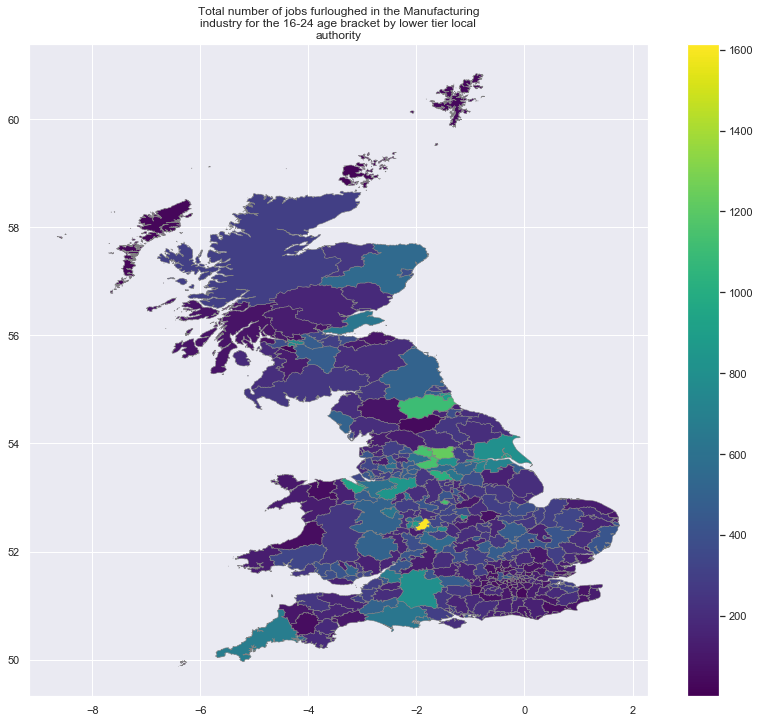

In [41]:
mergedData = geopandas.GeoDataFrame(mergedData)
fig, ax = plt.subplots(1, 1, figsize=(14,12))

mergedData.plot(column="Manu_16-24_Furloughed_jobs_2020-05-18", ax=ax, legend=True, cmap="viridis", linewidth=0.5, edgecolor='0.5')
## geopandas has excellent automatic plotting capabilities, inheriting matplotlib keywords
title = ax.set_title("\n".join(wrap("Total number of jobs furloughed in the Manufacturing industry for the 16-24 age bracket by lower tier local authority", 60)))

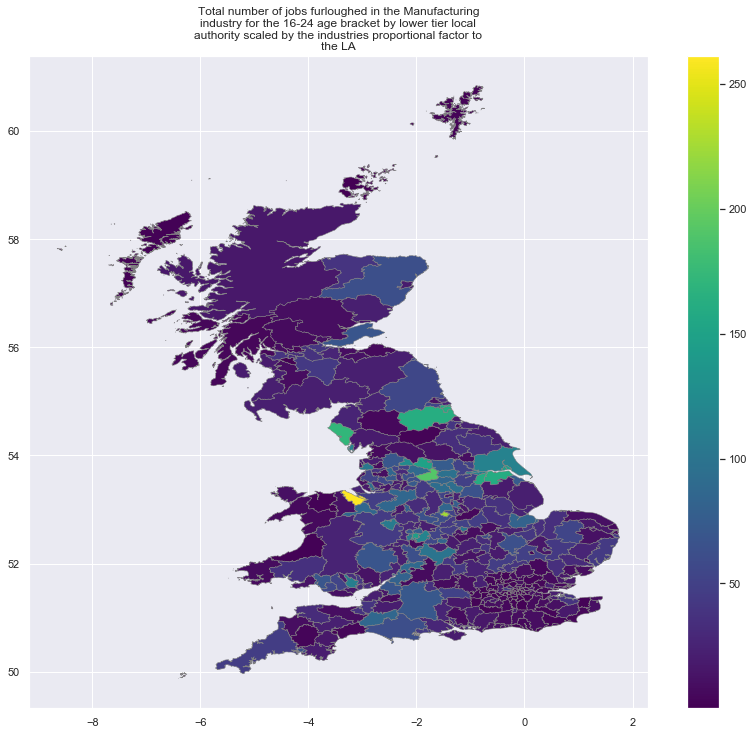

In [42]:
mergedData = geopandas.GeoDataFrame(mergedData)
fig, ax = plt.subplots(1, 1, figsize=(14,12))

mergedData.plot(column="Scaled Value", ax=ax, legend=True, cmap="viridis", linewidth=0.5, edgecolor='0.5')
title = ax.set_title("\n".join(wrap("Total number of jobs furloughed in the Manufacturing industry for the 16-24 age bracket by lower tier local authority scaled by the industries proportional factor to the LA", 60)))

## A look at the resulting data in tabular form

In [43]:
Manu16.sort_values(by="Manu_16-24_Furloughed_jobs_2020-05-18").head()

,Area,Manufacturing,Manufacturing_16-24,Manu_16-24_Furloughed_jobs_2020-05-18,Scaled Value
291,Isles of Scilly,20,2.123846,0.849539,0.012539
270,Epsom and Ewell,250,26.548081,10.619232,0.088229
361,Orkney Islands,400,42.476929,16.990772,0.522793
349,East Renfrewshire,600,63.715394,25.486158,0.678575
351,Na h-Eileanan Siar,700,74.334626,29.733851,1.344988


In [44]:
Manu16.sort_values(by="Manu_16-24_Furloughed_jobs_2020-05-18", ascending=False).head()

,Area,Manufacturing,Manufacturing_16-24,Manu_16-24_Furloughed_jobs_2020-05-18,Scaled Value
371,Column Total,2435000,258578.307195,103431.322878,8173.138770
129,Birmingham,38000,4035.308285,1614.123314,117.950629
70,Leeds,29000,3079.577375,1231.830950,75.139291
69,Kirklees,27000,2867.192729,1146.877091,191.264246
72,Derby,27000,2867.192729,1146.877091,224.064265


In [45]:
Manu16.sort_values(by="Scaled Value").head()

,Area,Manufacturing,Manufacturing_16-24,Manu_16-24_Furloughed_jobs_2020-05-18,Scaled Value
291,Isles of Scilly,20,2.123846,0.849539,0.012539
270,Epsom and Ewell,250,26.548081,10.619232,0.088229
188,City of London,2000,212.384647,84.953859,0.324419
194,Lambeth,1250,132.740404,53.096162,0.423955
361,Orkney Islands,400,42.476929,16.990772,0.522793


In [46]:
Manu16.sort_values(by="Scaled Value", ascending=False).head()

,Area,Manufacturing,Manufacturing_16-24,Manu_16-24_Furloughed_jobs_2020-05-18,Scaled Value
371,Column Total,2435000,258578.307195,103431.322878,8173.138770
321,Flintshire,22000,2336.231112,934.492445,261.230417
72,Derby,27000,2867.192729,1146.877091,224.064265
69,Kirklees,27000,2867.192729,1146.877091,191.264246
21,Copeland,12000,1274.307879,509.723152,171.455580


# Funnel/Confidence Interval plots

 "A funnel plot is a scatter plot of rates against population size. It compares results 
 from different populations over the same period, e.g. the referral rate for a 
 particular condition from a number of GP surgeries."

 The chart’s mean and limits identify populations for whom the rate is unusually high or low. 

 As significance depends on both population size and rate, outliers may not be those with 
 the highest or lowest rates.

 A point which falls outside these limits is unusual and you need to investigate it further.
 
 (More information here: https://improvement.nhs.uk/resources/funnel-plot-tool/)

In [47]:
## getting unique ages and industries/sectors to loop though
ageList = ageJobData.Age.unique()
indList = latestRates.Industry.unique()

In [48]:
aJD = ageJobData
fR = latestRates

## creating an empty list to fill with all the individual dfs that will then be concatenated together 
listOfDfs = []

for age in ageList:
    for ind in indList:
        ## loop to calculate the scaled values for each LA for individual LAs and industries (can be improved
        ## upon)
        tempDf = totalJobsSlice[["Area", ind]].drop(371)
        tempDfScale = totalJobsPercSlice[["Area", ind]].drop(371)
        totalJobsVal = tempDf[ind].sum()
        tempDf[ind+"_FACTOR"] = tempDf[ind]/totalJobsVal*100
        
        x = aJD[(aJD["Industry"]==ind) & (aJD["Age"]==age)]["Percentage of Jobs"].values[0]
        tempDf[str("TOTAL_JOBS_"+ind[:5]+"_"+age.strip())] = tempDf[ind]*x
        
        y = fR[(fR["Industry"] == ind)]
        rateDate = y["Date"].loc[y["Date"].first_valid_index()]
        rateDiv100 = y["Rate"].loc[y["Rate"].first_valid_index()] / 100
        tempDf[str("FUR_JOBS_"+ind[:5]+"_"+age.strip())] = tempDf[str("TOTAL_JOBS_"+ind[:5]+"_"+age.strip())]*rateDiv100
        
        tempDf[str("SCALED_"+ind[:5]+"_"+age.strip())] = tempDf[str("FUR_JOBS_"+ind[:5]+"_"+age.strip())] * tempDfScale[ind]
                
        dfFilter = tempDf
        dfFilter = dfFilter[["Area", str("SCALED_"+ind[:5]+"_"+age.strip()), ind]]
        dfFilter["Scaled"] = dfFilter[str("SCALED_"+ind[:5]+"_"+age.strip())]
        dfFilter["NumJobs"] = dfFilter[ind]
        dfFilter.drop(columns=[str("SCALED_"+ind[:5]+"_"+age.strip())], inplace=True)
        dfFilter.drop(columns=ind, inplace=True)
        dfFilter["Age"] = age
        dfFilter["Ind"] = ind
        dfFilter["AGE_JOBS"] = tempDf[str("TOTAL_JOBS_"+ind[:5]+"_"+age.strip())]
        listOfDfs.append(dfFilter)        

dfPrime = pd.concat(listOfDfs)

In [49]:
## Once we have the "master" dfPrime we can select industries and age groups to plot and investigate. You could
## try to produce the following plots iteratively by iterating thriugh the unique Industry and age values
dfPrimeM = dfPrime[dfPrime["Ind"]=="Manufacturing"]
dfPrimeM

,Area,Scaled,NumJobs,Age,Ind,AGE_JOBS
0,Darlington,14.144243,4000,16-24,Manufacturing,424.769293
1,County Durham,163.150024,26000,16-24,Manufacturing,2761.000405
2,Hartlepool,17.153202,3500,16-24,Manufacturing,371.673131
3,Middlesbrough,6.318360,3000,16-24,Manufacturing,318.576970
4,Northumberland,55.354550,12000,16-24,Manufacturing,1274.307879
...,...,...,...,...,...,...
366,South Ayrshire,7.465553,5000,65+,Manufacturing,179.453240
367,South Lanarkshire,14.551685,11000,65+,Manufacturing,394.797127
368,Stirling,2.588009,3000,65+,Manufacturing,107.671944
369,West Dunbartonshire,2.771907,2500,65+,Manufacturing,89.726620


In [50]:
## loading the population data for the uk so that we can scale our values into a rate for future plots and
## also compare this rate to the intermediary values that we have derived
dfPop = pd.read_csv("UK Population Density Data 2018.csv", thousands=",")

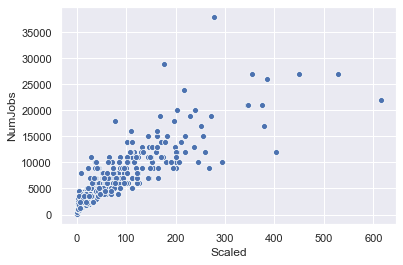

In [51]:
## grouping by area essentially removes the age breakdown from the data, in this case we are using the mean 
## of these 4 age values 
dfPrimeMGb = dfPrimeM.groupby(by=["Area"]).mean().reset_index()

dfPop.dropna(inplace=True)
dfPrimeMGb["Name"] = dfPrimeMGb["Area"]
## merging with the population data
dfPrimeMGb = pd.merge(dfPrimeMGb, dfPop, on="Name")

## now to produce some plots using our derived manufacturing data
sns.scatterplot(data=dfPrimeMGb, x="Scaled", y="NumJobs", ci="sd")

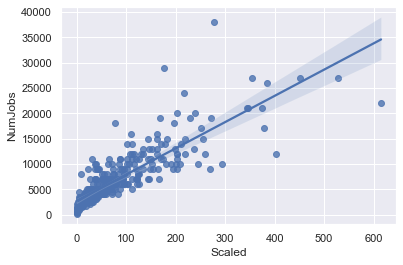

In [52]:
sns.regplot(data=dfPrimeMGb, x="Scaled", y="NumJobs")

In [53]:
dfPrimeMGb["NumJobsPer1000"] = dfPrimeMGb["NumJobs"] / dfPrimeMGb["Estimated Population mid-2018"] * 1000
dfPrimeMGb["ScalePer1000"] = dfPrimeMGb["Scaled"] / dfPrimeMGb["Estimated Population mid-2018"] * 1000

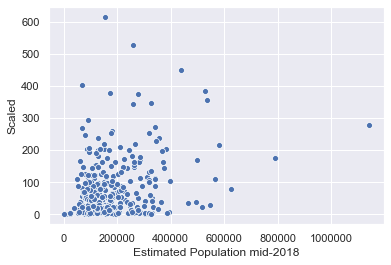

In [54]:
sns.scatterplot(data=dfPrimeMGb, y="Scaled", x="Estimated Population mid-2018", ci="sd")

## Indicator funnel

In [55]:
## now we are getting to the actual funnel plots
df = dfPrimeMGb[["Area", "Scaled", "NumJobs"]]
df.head()

,Area,Scaled,NumJobs
0,Aberdeen City,46.101309,9000
1,Aberdeenshire,147.020444,13000
2,Adur,28.742240,2500
3,Allerdale,61.538462,5000
4,Amber Valley,200.440970,10000


In [56]:
df["Rate"] = df["Scaled"] / df["NumJobs"]
df["AVG Rate"] = df.Rate.mean()
df["SE"] = np.sqrt(df["AVG Rate"] * (1-df["AVG Rate"]) / df["NumJobs"])
df["95 upper"] = df["AVG Rate"] +(1.96*df["SE"])
df["95 lower"] = df["AVG Rate"] -(1.96*df["SE"])
df["99.8 upper"] = df["AVG Rate"] +(3*df["SE"])
df["99.8 lower"] = df["AVG Rate"] -(3*df["SE"])

df = df.sort_values(by="NumJobs")
df_no_age_saved = df
## Make the df a bit smaller to reduce clutter on the plots themselves
dfFrac = df.sample(frac=0.5).sort_values(by="NumJobs")
dfFrac.head()

,Area,Scaled,NumJobs,Rate,AVG Rate,SE,95 upper,95 lower,99.8 upper,99.8 lower
106,East Renfrewshire,1.597515,600,0.002663,0.009321,0.003923,0.017010,0.001632,0.021090,-0.002448
315,Tandridge,3.004808,1000,0.003005,0.009321,0.003039,0.015277,0.003365,0.018437,0.000205
179,Lewisham,2.342579,1250,0.001874,0.009321,0.002718,0.014648,0.003994,0.017475,0.001167
58,Ceredigion,4.670453,1250,0.003736,0.009321,0.002718,0.014648,0.003994,0.017475,0.001167
73,Conwy,3.107288,1250,0.002486,0.009321,0.002718,0.014648,0.003994,0.017475,0.001167


[Text(0, 0.5, 'Indicator divided by the Total number of Jobs in Industry per Area'),
 Text(0.5, 1.0, 'Funnel plot for the manufacturing industry in the UK, showing the under and over performing LAs according to a scaling metric')]

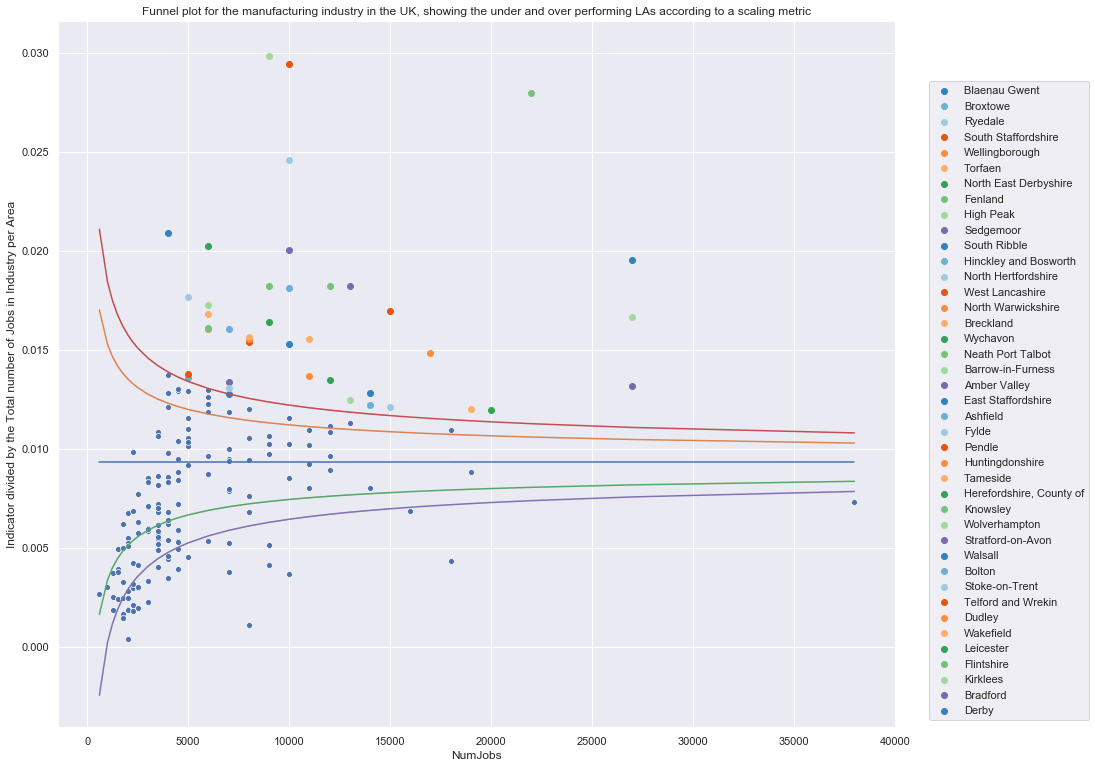

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(15,13))
sns.lineplot(data=dfFrac, x="NumJobs", y="AVG Rate", ax=ax)
sns.lineplot(data=dfFrac, x="NumJobs", y="95 upper", ax=ax)
sns.lineplot(data=dfFrac, x="NumJobs", y="95 lower", ax=ax)
sns.lineplot(data=dfFrac, x="NumJobs", y="99.8 upper", ax=ax)
sns.lineplot(data=dfFrac, x="NumJobs", y="99.8 lower", ax=ax)
sns.scatterplot(data=dfFrac, x="NumJobs", y="Rate", ax=ax)
count=0
## custom cmap to help distinguish points compared to sequential/diverging cmaps
colors =  plt.cm.tab20c( (4./3*np.arange(20*3/4)).astype(int) )
for col, row in dfFrac.iterrows():
    if row["Rate"] > row["99.8 upper"]:
        plt.scatter(y=row["Rate"], x=row["NumJobs"], label=row["Area"], color=colors[count])
        count +=1
        ## for cycling through the colour palette/cmap
        if count == 10:
            count = 0
plt.legend(numpoints=1, loc=(1.04,0.01))
#ax.legend(loc=(1.04,0), numpoints=10)
ax.set(ylabel="Indicator divided by the Total number of Jobs in Industry per Area",
      title="Funnel plot for the manufacturing industry in the UK, showing the under and over performing LAs according to a scaling metric")

### Same with age breakdown

In [58]:
dfPrimeM.head()

,Area,Scaled,NumJobs,Age,Ind,AGE_JOBS
0,Darlington,14.144243,4000,16-24,Manufacturing,424.769293
1,County Durham,163.150024,26000,16-24,Manufacturing,2761.000405
2,Hartlepool,17.153202,3500,16-24,Manufacturing,371.673131
3,Middlesbrough,6.318360,3000,16-24,Manufacturing,318.576970
4,Northumberland,55.354550,12000,16-24,Manufacturing,1274.307879


In [59]:
dfPop = pd.read_csv("UK Population Density Data 2018.csv", thousands=",")
dfPop.dropna(inplace=True)
dfPrimeM["Name"] = dfPrimeM["Area"]

dfPrimeM = pd.merge(dfPrimeM, dfPop, on="Name")
dfPrimeM = dfPrimeM[["Area", "Scaled", "AGE_JOBS", "Age"]]
dfPrimeM.head()

,Area,Scaled,AGE_JOBS,Age
0,Darlington,14.144243,424.769293,16-24
1,Darlington,77.078263,2314.756584,25-49
2,Darlington,37.191643,1116.911531,50-64
3,Darlington,4.780440,143.562592,65+
4,County Durham,163.150024,2761.000405,16-24


In [60]:
df = dfPrimeM

In [61]:
df["Rate"] = df["Scaled"] / df["AGE_JOBS"]
df["AVG Rate"] = df.Rate.mean()
df.head(6)

,Area,Scaled,AGE_JOBS,Age,Rate,AVG Rate
0,Darlington,14.144243,424.769293,16-24,0.033299,0.037284
1,Darlington,77.078263,2314.756584,25-49,0.033299,0.037284
2,Darlington,37.191643,1116.911531,50-64,0.033299,0.037284
3,Darlington,4.780440,143.562592,65+,0.033299,0.037284
4,County Durham,163.150024,2761.000405,16-24,0.059091,0.037284
5,County Durham,889.076961,15045.917799,25-49,0.059091,0.037284


In [62]:
df["SE"] = np.sqrt(df["AVG Rate"] * (1-df["AVG Rate"]) / df["AGE_JOBS"])
df.head()

,Area,Scaled,AGE_JOBS,Age,Rate,AVG Rate,SE
0,Darlington,14.144243,424.769293,16-24,0.033299,0.037284,0.009192
1,Darlington,77.078263,2314.756584,25-49,0.033299,0.037284,0.003938
2,Darlington,37.191643,1116.911531,50-64,0.033299,0.037284,0.005669
3,Darlington,4.780440,143.562592,65+,0.033299,0.037284,0.015812
4,County Durham,163.150024,2761.000405,16-24,0.059091,0.037284,0.003606


In [63]:
df["95 upper"] = df["AVG Rate"] +(1.96*df["SE"])
df["95 lower"] = df["AVG Rate"] -(1.96*df["SE"])
df["99.8 upper"] = df["AVG Rate"] +(3*df["SE"])
df["99.8 lower"] = df["AVG Rate"] -(3*df["SE"])
df = df.sort_values(by="AGE_JOBS")
dfFrac = df.sample(frac=0.25).sort_values(by="AGE_JOBS")
dfFrac.head()

,Area,Scaled,AGE_JOBS,Age,Rate,AVG Rate,SE,95 upper,95 lower,99.8 upper,99.8 lower
1164,Isles of Scilly,0.012539,2.123846,16-24,0.005904,0.037284,0.130001,0.292087,-0.217519,0.427288,-0.352720
1166,Isles of Scilly,0.032972,5.584558,50-64,0.005904,0.037284,0.080171,0.194418,-0.119851,0.277796,-0.203228
1083,Epsom and Ewell,0.029819,8.972662,65+,0.003323,0.037284,0.063248,0.161251,-0.086683,0.227029,-0.152461
1165,Isles of Scilly,0.068332,11.573783,25-49,0.005904,0.037284,0.055689,0.146435,-0.071867,0.204352,-0.129784
1080,Epsom and Ewell,0.088229,26.548081,16-24,0.003323,0.037284,0.036770,0.109353,-0.034785,0.147594,-0.073026


[(-0.025, 0.15),
 Text(0, 0.5, 'Indicator divided by the Total number of Jobs in Industry per Area'),
 Text(0.5, 1.0, 'Funnel plot for the manufacturing industry in the UK, showing the under and over performing LAs according to a scaling metric with Age group breakdown')]

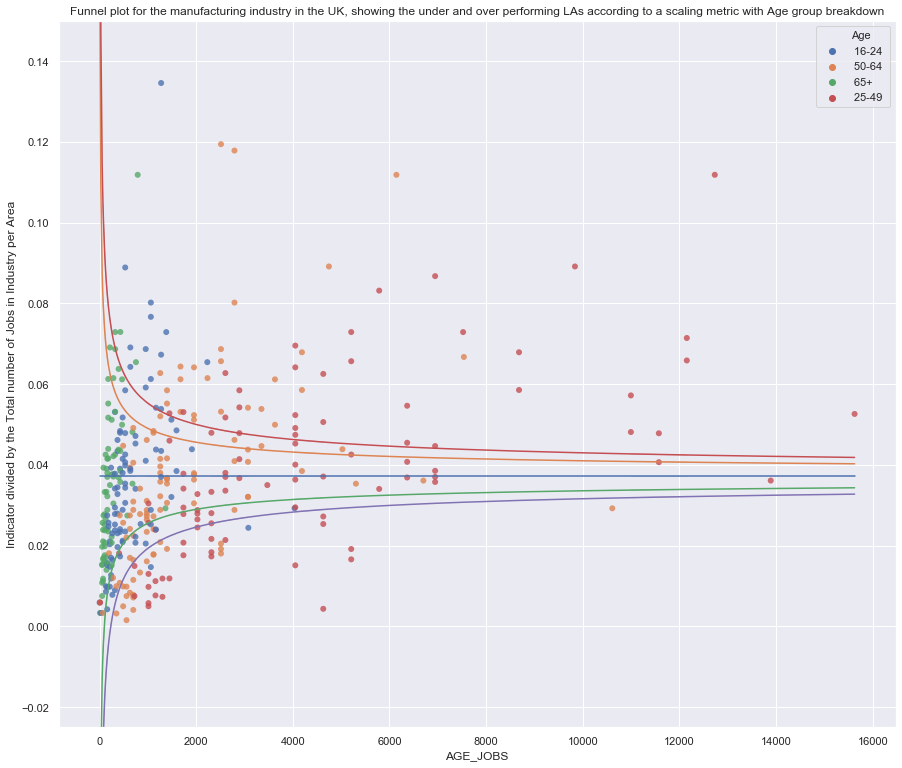

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(15,13))
sns.lineplot(data=dfFrac, x="AGE_JOBS", y="AVG Rate", ax=ax)
sns.lineplot(data=dfFrac, x="AGE_JOBS", y="95 upper", ax=ax)
sns.lineplot(data=dfFrac, x="AGE_JOBS", y="95 lower", ax=ax)
sns.lineplot(data=dfFrac, x="AGE_JOBS", y="99.8 upper", ax=ax)
sns.lineplot(data=dfFrac, x="AGE_JOBS", y="99.8 lower", ax=ax)
sns.scatterplot(data=dfFrac, x="AGE_JOBS", y="Rate", ax=ax, hue="Age", alpha=0.8, linewidth=0)

ax.set(ylabel="Indicator divided by the Total number of Jobs in Industry per Area",
      title="Funnel plot for the manufacturing industry in the UK, showing the under and over performing LAs according to a scaling metric with Age group breakdown",
      ylim=(-0.025, 0.15))

## Choropleth chart

In [65]:
df = df_no_age_saved
df = df.sort_values(by="NumJobs", ascending=False)
df["Indicator"] = "3. Normal Variation"
df = pd.merge(df, geoData, on="Area")
df.columns

Index(['Area', 'Scaled', 'NumJobs', 'Rate', 'AVG Rate', 'SE', '95 upper',
       '95 lower', '99.8 upper', '99.8 lower', 'Indicator', 'bng_e', 'bng_n',
       'lad17cd', 'lad17nm', 'lad17nmw', 'lat', 'long', 'objectid',
       'st_areashape', 'st_lengthshape', 'geometry', 'AREA_CODE'],
      dtype='object')

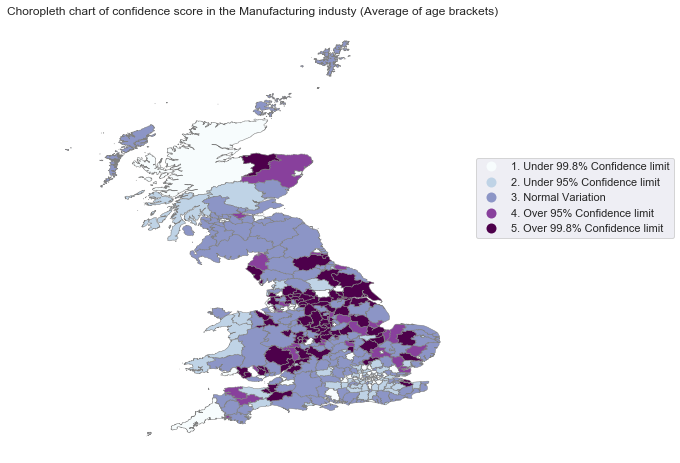

In [66]:
for index, row in df.iterrows():
    if row["Rate"] > row["99.8 upper"]:
        df.loc[index, "Indicator"] = "5. Over 99.8% Confidence limit"
    elif (row["Rate"] <= row["99.8 upper"]) & (row["Rate"] > row["95 upper"]):
        df.loc[index, "Indicator"] = "4. Over 95% Confidence limit"
    elif (row["Rate"] >= row["99.8 lower"]) & (row["Rate"] < row["95 lower"]):
        df.loc[index, "Indicator"] = "2. Under 95% Confidence limit"
    if row["Rate"] < row["99.8 lower"]:
        df.loc[index, "Indicator"] = "1. Under 99.8% Confidence limit"

#df = df.sort_values(by="Indicator", ascending=True)
        
fig, ax = plt.subplots(1, 1, figsize=(14,8))
plt.axis('off')
df = geopandas.GeoDataFrame(df)    
df.plot(column="Indicator", ax=ax, legend=True, cmap="BuPu", linewidth=0.5, edgecolor='0.5', legend_kwds={"loc":(1.04,0.5)})
title = ax.set_title("Choropleth chart of confidence score in the Manufacturing industy (Average of age brackets)") 